In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from pandas import DataFrame
from pennylane.templates.embeddings import AmplitudeEmbedding

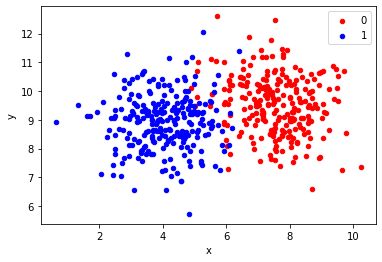

In [2]:
# generate 2d classification dataset
features, labels = make_blobs(n_samples=500, centers=2, n_features=16)

# scatter plot, dots colored by class value
df = DataFrame(dict(x=features[:,0], y=features[:,1], label=labels))

colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [3]:
dev = qml.device("default.qubit", wires=4)

In [4]:
def layer(W):

    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

In [5]:
def statepreparation(x):
    AmplitudeEmbedding(features=x, wires=[0, 1, 2, 3],normalize="True")

In [6]:
@qml.qnode(dev)
def circuit(weights, x):

    statepreparation(x)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

In [7]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [8]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [9]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [10]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [11]:
X = np.array(features, requires_grad=False)
Y = np.array(labels, requires_grad=False)
Y = Y * 2 - np.ones(len(Y))  # shift label from {0, 1} to {-1, 1}

for i in range(5):
    print("X = {}, Y = {: d}".format(X[i], int(Y[i])))
    
######

np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

X = [ 8.95622687  7.69379096 -6.70465748  4.24016276  4.62700671  2.93521552
  4.34076463  6.89291022 -8.62672292 -2.58876017 -7.84507024  5.88358241
 -0.99277275  0.25157788 -8.3322107   3.31507591], Y = -1
X = [  3.47551045   7.80937602   9.82751954 -10.37554072   6.63996345
  -2.23131919   7.97629672   3.8483499    0.17221987   7.12318987
   3.94967525   0.9789792    1.85518955  -7.21624465  -8.08248391
  -6.00514045], Y =  1
X = [ 7.00089925 10.017248   -6.76919973  4.1769577   5.2713855   4.445373
  3.6874947   6.40309056 -8.290264   -0.70789877 -6.80465005  7.82584615
 -0.35941163  1.07149591 -7.30264941  2.12762649], Y = -1
X = [ 7.53647151 12.48675377 -6.43448853  5.86520887  6.27640522  2.83461639
  3.7550088   5.04690856 -9.30025514 -4.29432118 -4.6350465  10.3461298
 -1.56272572  0.20389512 -8.68153982  4.57326595], Y = -1
X = [ 7.39352     9.9303399  -7.37882649  5.00921781  3.11927397  2.21983274
  4.18565454  7.39210137 -7.66550517 -3.74302855 -8.77703089  7.20697829
 -1.

In [12]:
np.random.seed(0)
num_qubits = 4
num_layers = 3
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print(weights_init, bias_init)

[[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]

 [[ 0.02269755 -0.01454366  0.00045759]
  [-0.00187184  0.01532779  0.01469359]
  [ 0.00154947  0.00378163 -0.00887786]
  [-0.01980796 -0.00347912  0.00156349]]] 0.0


In [13]:
opt = NesterovMomentumOptimizer(0.1)
batch_size = 5

weights = weights_init
bias = bias_init

history_train = []
history_validation = []

for it in range(15):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    X_train_batch = X_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in X_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in X_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    
    history_train.append(acc_train)
    history_validation.append(acc_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost: 1.2580159 | Acc train: 0.4906667 | Acc validation: 0.5280000 
Iter:     2 | Cost: 0.6667909 | Acc train: 0.7146667 | Acc validation: 0.7920000 
Iter:     3 | Cost: 0.3650685 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:     4 | Cost: 0.3293577 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:     5 | Cost: 0.2763588 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:     6 | Cost: 0.2683290 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:     7 | Cost: 0.2656435 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:     8 | Cost: 0.2383048 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:     9 | Cost: 0.1752587 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:    10 | Cost: 0.1317691 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:    11 | Cost: 0.1316872 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:    12 | Cost: 0.1768869 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:    13 | Co

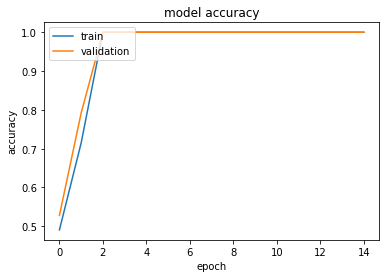

In [14]:
plt.plot(history_train)
plt.plot(history_validation)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()